In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
import multitask.models.task_switching.hooks as hooks
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
num_tasks = len(tasks_names)

In [5]:
num_layers = len(num_hidden)
list_results = []

for max_contexts in range(1, num_layers+1):

    idxs_contexts = list(range(max_contexts))
    print(idxs_contexts)

    parameters = {
        'num_runs': num_runs,
        'initial_seed': initial_seed,
        'max_seed': max_seed,
        'num_epochs': num_epochs,
        'num_hidden': num_hidden,
        'batch_size': batch_size,
        'num_train': num_train,
        'num_test': num_test,
        'tasks': tasks_names,
        'idxs_contexts': idxs_contexts
    }

    data_folder = check_runs(path_model_task_switching, parameters)

    pickle_data = os.path.join(data_folder, 'data.pickle')
    with open(pickle_data, 'rb') as handle:
        results_task_switching = pickle.load(handle)
    list_results.append(results_task_switching)


[0]
Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_11)
[0, 1]
Found simulation in ../../results/task_switching with the same parameters (2022-09-27_23_23_59)
[0, 1, 2]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_10_57)
[0, 1, 2, 3]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_01_01_30)
[0, 1, 2, 3, 4]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_01_39)
[0, 1, 2, 3, 4, 5]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_03_03_56)
[0, 1, 2, 3, 4, 5, 6]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_04_08_03)
[0, 1, 2, 3, 4, 5, 6, 7]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_05_03_47)
[0, 1, 2, 3, 4, 5, 6, 7, 8]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_06

In [6]:
if num_tasks > 2:
    raise NotImplementedError

In [7]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

/home/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-ex__3qls/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


parity: [1, 0]
value: [0, 1]


In [8]:
criterion = nn.CrossEntropyLoss()
device = get_device()

acc_test_parity = np.zeros((num_runs, num_layers))
acc_test_value = np.zeros((num_runs, num_layers))
acc_test_joint = np.zeros((num_runs, num_layers))

for i_results, results in tqdm(enumerate(list_results), total=len(list_results)):
    seeds = list(results.keys())
    idxs_contexts = list(range(i_results + 1))
    for j_seed, seed in enumerate(seeds):
        state_dict = results[seed]['model']
        model = get_task_model(task_switching_tasks,
                               num_hidden,
                               idxs_contexts,
                               device)
        model.load_state_dict(state_dict)
        
        indices = results[seed]['indices']

        test_sampler = dataset.SequentialSampler(indices['test'])
        _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                            indices,
                                                            batch_size=batch_size)
        tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

        numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
        numbers = numbers[indices['test']]

        acc_test_increase, _ = hooks.get_layer_activations(model,
                                                           tasks_testloader,
                                                           criterion,
                                                           device=device,
                                                           disable=True)
        
        acc_test_parity[j_seed, i_results] = acc_test_increase['parity'].mean()
        acc_test_value[j_seed, i_results] = acc_test_increase['value'].mean()
        acc_test_joint[j_seed, i_results] = (acc_test_increase['parity'] * acc_test_increase['value']).mean()

  0%|          | 0/10 [00:00<?, ?it/s]

Running on GPU.


100%|██████████| 10/10 [00:41<00:00,  4.17s/it]


In [9]:
accuracies_df = pd.DataFrame(columns=['Acc', 'Idx', 'Task'])

# for i_acc_parity, acc_parity in enumerate(acc_test_parity.T):
#     parity_df = pd.DataFrame({'Acc': acc_parity, 'Idx': i_acc_parity, 'Task': 'Parity'})
#     accuracies_df = pd.concat((accuracies_df, parity_df))

# for i_acc_value, acc_value in enumerate(acc_test_value.T):
#     value_df = pd.DataFrame({'Acc': acc_value, 'Idx': i_acc_value, 'Task': 'Value'})
#     accuracies_df = pd.concat((accuracies_df, value_df))

for i_acc_joint, acc_joint in enumerate(acc_test_joint.T):
     joint_df = pd.DataFrame({'Acc': acc_joint, 'Idx': i_acc_joint, 'Task': 'Joint'})
     accuracies_df = pd.concat((accuracies_df, joint_df))

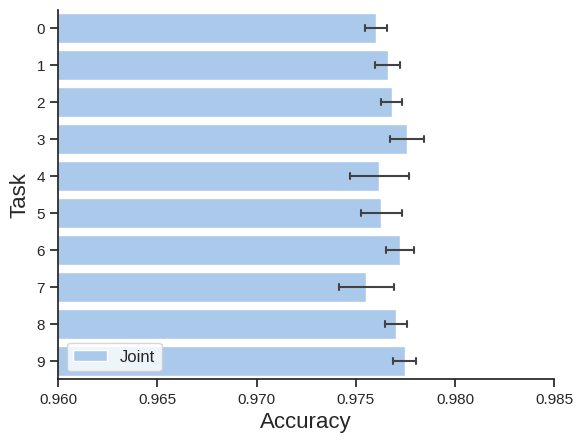

In [10]:
fig = plt.figure()
sns.barplot(x='Acc', y='Idx', hue='Task', data=accuracies_df, errorbar=('se'), errwidth=1.5, capsize=0.15, orient='horizontal')
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('Task', fontsize=16)
plt.xlim(0.96, 0.985)
plt.legend(loc='lower left', prop={'size':12})

# fig.savefig('figures/figure05/fig05a_acc_weights_contexts_increase.svg')
plt.show()

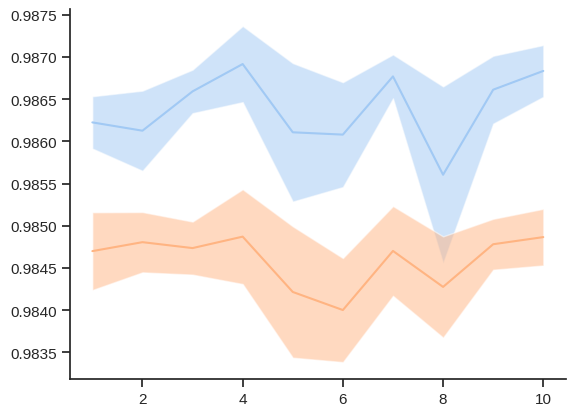

In [11]:
layers = range(1, num_layers+1)

mean_acc_parity = acc_test_parity.mean(axis=0)
std_acc_parity = acc_test_parity.std(axis=0) / np.sqrt(num_runs)

mean_acc_value = acc_test_value.mean(axis=0)
std_acc_value = acc_test_value.std(axis=0) / np.sqrt(num_runs)

plt.plot(layers, mean_acc_parity)
plt.plot(layers, mean_acc_value)

plt.fill_between(layers,
                 mean_acc_parity-std_acc_parity,
                 mean_acc_parity+std_acc_parity,
                 alpha=0.5)

plt.fill_between(layers,
                 mean_acc_value-std_acc_value,
                 mean_acc_value+std_acc_value,
                 alpha=0.5)

plt.show()